In [1]:
import socket
import hmac
import numpy as np
from PIL import Image

def combine_pixel_groups_into_image(groups):
    combined_image = Image.new('RGB', (1979,1180 ))
    x = 0
    y = 0
    for i in sorted(groups.keys()):
        combined_image.paste(groups[i], (x, y, x + groups[i].width, y + groups[i].height))
        x += groups[i].width
        if x >= 1979:
            x = 0
            y += groups[i].height

    return combined_image

def receive_raw_image(output_path, ip, port):
    # Create a UDP socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.bind((ip, port))

    print(f"Listening on port {port} for  image...")

    chunk_size =4096
    chunks = {}
    expected_chunk_index = 0

    while True:
        data, addr = sock.recvfrom(chunk_size+ 4 + 48)  # 8 bytes for index + 1024 bytes of data
        if data == b'END':
            break

        # Extract the chunk index and chunk data
        chunk_index = int.from_bytes(data[:4], 'big')
        chunk_data = data[4:-48]
        mac = data[-48:]

        # Verify the HMAC
        if hmac.new(b'key', chunk_data, 'sha384').digest() != mac:
            print(f"Invalid HMAC for chunk {chunk_index}")
            continue

        chunks[chunk_index] = Image.fromarray(np.frombuffer(chunk_data, dtype=np.uint8).reshape((6, 5, 3)))
        # print(f"Received chunk {chunk_index} from {addr}")

    for i in range(78012):
        if i not in chunks.keys():
            print(f"Missing chunk {i}")
            chunks[i] = Image.new("RGB", (5, 6), (0, 0, 0))
        
    # Reassemble the chunks
    with open(output_path, 'wb') as f:
        for i in sorted(chunks.keys()):
            f.write(chunks[i].tobytes())

    print(f"BMP image saved to {output_path}")
    print(type(chunks), len(chunks),)
    return chunks

# Example usage
output_path = 'received_image.NEF'
server_ip = '0.0.0.0'
listen_port = 23423
chunks = receive_raw_image(output_path, server_ip, listen_port)

Listening on port 23423 for  image...
Missing chunk 53
Missing chunk 9565
Missing chunk 22730
Missing chunk 23509
Missing chunk 30730
Missing chunk 39350
Missing chunk 55752
Missing chunk 58595
Missing chunk 62411
Missing chunk 64010
BMP image saved to received_image.NEF
<class 'dict'> 78012


In [5]:
chunks[68195]


In [6]:
combined_image = combine_pixel_groups_into_image(chunks)

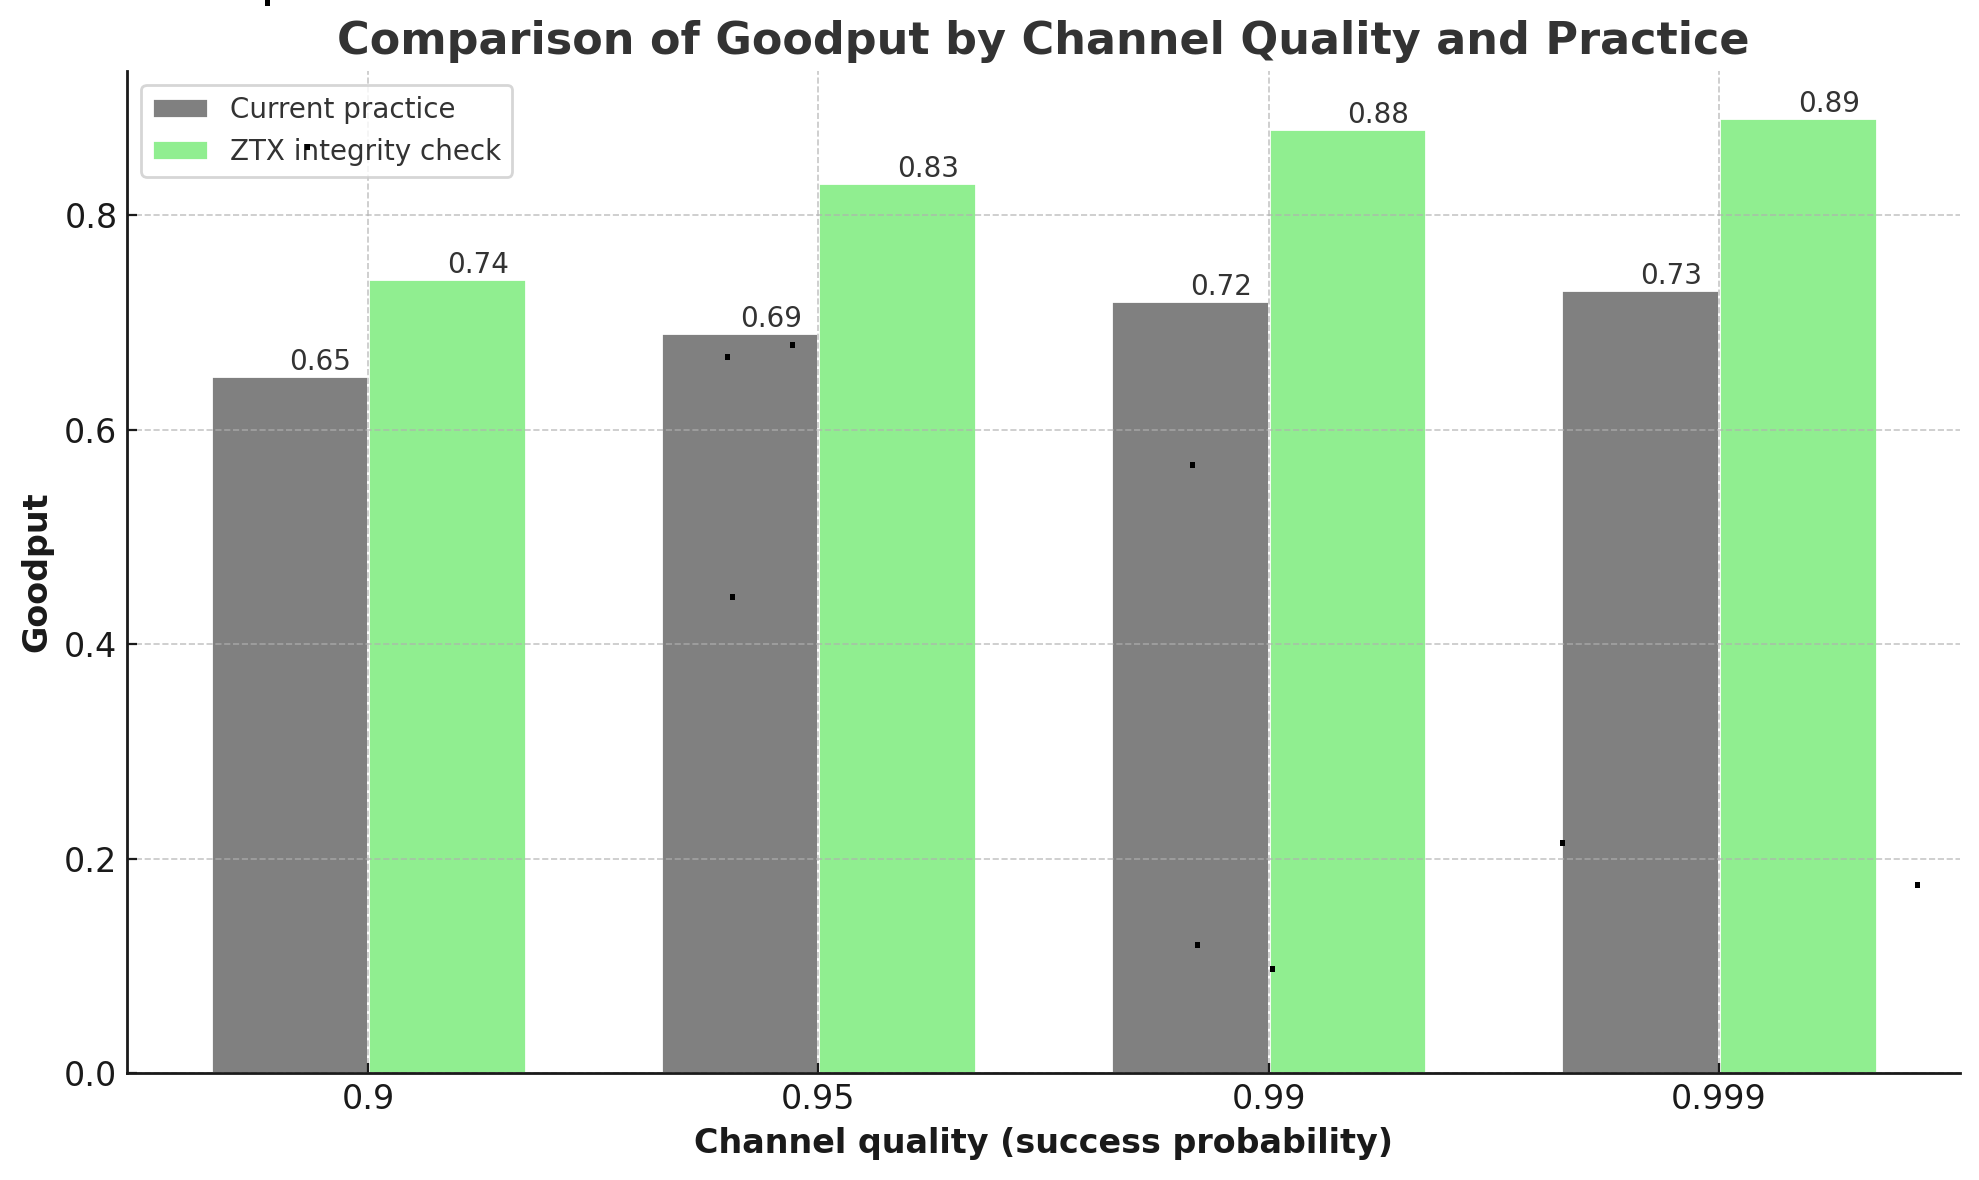

In [7]:
combined_image